In [2]:
import torch
import torch.nn as nn


**Embed_size:** embedding

**Heads:** Number of multihead attentions

**Head_dim:**
how many times embeddings are split (eg, 256 (embeddings dim/8 (heads) = 32 parts

With heads = 2, the 16-dimensional embedding vector is split into 2 parts, each of 8 dimensions.

For the word "I":

Head 1: [0.1, 0.2, ..., 0.08] (8 dimensions)

Head 2: [0.09, 0.1, ..., 0.15] (8 dimensions)

### NN.Module

nn.Module is a base class for all neural network modules in PyTorch. It provides a way to encapsulate the parameters, state, and behavior of a neural network layer or a model. By subclassing nn.Module, you can create custom neural network layers or models with their own forward pass, parameters, and other attributes.

### NN.Linear

The transformation performed by nn.Linear can be represented as:

𝑦
=
𝑥
𝑊
𝑇
+
𝑏


where:

𝑥 is the input data.

𝑊 is the weight matrix.

𝑏 is the bias vector.

𝑦 is the output data.

```
import torch
from torch import nn

# Define the linear layer
linear_layer = nn.Linear(in_features=10, out_features=5, bias=True)
```

**How the Linear Transformation Works**

**Weight Matrix:** The weight matrix W is multiplied with the input tensor x. This operation is equivalent to a matrix multiplication.

**Bias Vector:** The bias vector b is added to the output of the weight matrix multiplication.

**Output:** The final output tensor y is the result of the linear transformation.

### Example Output
Suppose the weight matrix `W` is:
```python
W = torch.tensor([[1, 2, 3, 4, 5],
                  [6, 7, 8, 9, 10]])
```
And the bias vector `b` is:
```python
b = torch.tensor([1, 2, 3, 4, 5])
```
If we apply the linear transformation to the input tensor `x`:
```python
x = torch.randn(1, 10)
```
The output tensor `y` would be:
```python
y = torch.tensor([[ 14.,  31.,  48.,  65.,  82.]])
```

In this example, the linear layer maps the input features to a new set of features by multiplying the input tensor with the weight matrix and adding the bias vector. This is a fundamental operation in neural networks and is used extensively in various models.


### Reshape:

The dimensions (N, value_len, embed_size) are assumed for values, keys, and queries before any transformations or reshaping. This assumption comes from the context that these are input embeddings typically used in transformer models.


Let's assume:

embed_size = 16

heads = 2

Therefore, self.head_dim = embed_size // heads = 16 // 2 = 8

Given an input batch of sequences where N = 2 (batch size), and seq_len = 3 (sequence length):

Initial Shape:

values, keys, query each have the shape (2, 3, 16).

After Reshaping:

```
values = values.reshape(2, 3, 2, 8)
keys = keys.reshape(2, 3, 2, 8)
queries = query.reshape(2, 3, 2, 8)
```

New shape: (batch_size, seq_len, heads, head_dim)


```value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]```

1-index of values.shape, keys.shape, and query.shape is to get the length of the input sequence (i.e., the number of tokens or elements in the input).


``` values.reshape(N, value_len, self.heads, self.head_dim)```

N = 32 (batch size)

value_len = 10 (sequence length)

self.heads = 8 (number of attention heads)

self.head_dim = 64 (dimension of each attention head)

Then, the resulting dimension of the values tensor after the reshape operation would be:

(32, 10, 8, 64)


---


The high-dimensional reshaping of the values, keys, and queries tensors in the self-attention mechanism is done for a few key reasons:

**Parallelization:**

Reshaping the tensors into a 4-dimensional structure (batch_size, sequence_length, num_heads, head_dim) allows the self-attention computation to be parallelized across the attention heads.

**Representation Learning:**

Splitting the embedding dimension into multiple heads (num_heads) and projecting them into a lower-dimensional space (head_dim) allows the model to learn different types of relationships and interactions between the input elements. This multi-head attention mechanism has been shown to be more expressive and powerful than a single attention mechanism.

**Tensor Manipulation:**

The 4-dimensional structure of the tensors makes it easier to perform various tensor operations required for the self-attention computation, such as computing the dot product between the queries and keys, applying the softmax function, and computing the weighted sum of the values.



---
### torch.einsum

This energy tensor represents the attention scores, which are the dot products between the query and key vectors for each position in the sequence, for each attention head. These attention scores will be used in the next step of the self-attention mechanism to compute the weighted sum of the values.

The line of code you provided:

```python
energy = torch.einsum('nqhd, nkhd->nhqk', [queries, keys])  # (N, heads, query_len, key_len)
```
2. **`'nqhd, nkhd->nhqk'`**: This is the Einstein summation notation that defines the operation to be performed. It specifies the dimensions of the input tensors and the desired output tensor dimensions.
   - `'nqhd'`: This represents the dimensions of the `queries` tensor, where:
     - `n`: Batch size
     - `q`: Query length
     - `h`: Number of heads
     - `d`: Head dimension
   - `'nkhd'`: This represents the dimensions of the `keys` tensor, where:
     - `n`: Batch size
     - `k`: Key length
     - `h`: Number of heads
     - `d`: Head dimension
   - `'nhqk'`: This represents the desired output tensor dimensions, where:
     - `n`: Batch size
     - `h`: Number of heads
     - `q`: Query length
     - `k`: Key length

3. **`[queries, keys]`**: This is the list of input tensors, in this case, the `queries` and `keys` tensors.

The result of this operation is a tensor `energy` with the shape `(N, heads, query_len, key_len)`, where:
- `N` is the batch size
- `heads` is the number of attention heads
- `query_len` is the length of the query sequence
- `key_len` is the length of the key sequence

This `energy` tensor represents the attention scores, which are the dot products between the query and key vectors for each position in the sequence, for each attention head. These attention scores will be used in the next step of the self-attention mechanism to compute the weighted sum of the values.

The reason for using `torch.einsum` here is that it provides a concise and efficient way to perform this tensor operation, which is a crucial step in the self-attention computation. It allows the computation to be performed in a parallelized manner across the attention heads, which is important for the performance of transformer-based models.

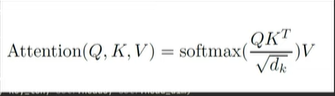

In [3]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size # size of embedding
    self.heads = heads # Number of multi-heads
    self.head_dim = embed_size // heads # The size of each embedding after going to multi head attention

    assert (self.head_dim * heads == embed_size), "Embed size must be divisible by heads"

    # the first argument is the size of input and the second is the dimension of output
    self.values=nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.keys=nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.queries=nn.Linear(self.head_dim, self.head_dim, bias=False)

    # this is the fully connected out which is the output after multihead output
    self.fc_out=nn.Linear(heads * self.head_dim, embed_size)

  def forward (self, values, keys, query, mask):
    N=query.shape[0] # batch size

    # 1-index of values.shape, keys.shape, and query.shape is to get the length of the input sequence (i.e., the number of tokens or elements in the input).
    value_len, key_len, query_len=values.shape[1], keys.shape[1], query.shape[1]

    # Split embedding into self.heads pieces
    values=values.reshape(N, value_len, self.heads, self.head_dim)
    keys=keys.reshape(N, key_len, self.heads, self.head_dim)
    queries=query.reshape(N, query_len, self.heads, self.head_dim)

    energy=torch.einsum('nqhd, nkhd->nhqk', [queries, keys]) # (N, heads, query_len, key_len)

    # queries shape= (N, query_len, heads, heads_dim)
    # key shape= (N, key_len, heads, heads_dim)
    # energy shape= (N, query_len, heads, heads_dim)

    if mask is not None:
      energy= energy.masked_fill(mask==0, float('-1e20')) # -1e20= -inf

    attention=torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) # (N, heads, query_len, key_len)

    out=torch.einsum('nhql, nlhd->nqhd', [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
    # attenion shape: (N, heads, query_len, key_len)
    # value shape: (N, value_len, heads, heads_len)
    # (N, query_len,heads, heads_dim)

    # fc_out will map the embedd size to embedd_size
    out=self.fc_out(out)
    return out



---
## Feed Forward


```python
self.feed_forward = nn.Sequential(
    nn.Linear(embed_size, forward_expansion * embed_size),
    nn.ReLU(),
    nn.Linear(forward_expansion * embed_size, embed_size)
)
```

1. **`nn.Sequential`**: This is a PyTorch module that allows you to stack multiple layers sequentially. It takes a list of layers as input and applies them in the order they are provided.

2. **`nn.Linear(embed_size, forward_expansion * embed_size)`**: This is the first linear layer in the feed-forward network. It takes an input of size `embed_size` and produces an output of size `forward_expansion * embed_size`. The `forward_expansion` parameter is likely a hyperparameter that determines the expansion factor for the feed-forward network.

3. **`nn.ReLU()`**: This is a ReLU (Rectified Linear Unit) activation function, which applies the non-linear transformation `max(0, x)` to the input.

4. **`nn.Linear(forward_expansion * embed_size, embed_size)`**: This is the second linear layer in the feed-forward network. It takes an input of size `forward_expansion * embed_size` and produces an output of size `embed_size`, effectively mapping the expanded representation back to the original embedding size.

The purpose of this feed-forward network is to provide additional modeling capacity to the self-attention mechanism. After the self-attention computation, the output is passed through this feed-forward network, which can learn to apply additional transformations to the input.

The feed-forward network is a common component in transformer-based models, such as BERT and GPT, and it has been shown to be an important part of the overall model architecture. The combination of self-attention and the feed-forward network allows the model to learn complex relationships in the input data.

In the context of the self-attention mechanism, the `embed_size` parameter represents the dimensionality of the input embeddings, and the `forward_expansion` parameter determines the degree of expansion in the feed-forward network. These hyperparameters can be tuned to optimize the performance of the overall model.

## Dropout

`self.dropout = nn.Dropout(dropout)` is creating a PyTorch `nn.Dropout` layer, which is a commonly used regularization technique in deep learning models to prevent overfitting.

1. **Dropout**: The dropout operation randomly sets a fraction of the input units to 0 during the training phase. This helps to prevent the model from overfitting by reducing the co-adaptation of neurons.

2. **Dropout Rate**: The `dropout` parameter passed to the `nn.Dropout` constructor specifies the fraction of the input units to be dropped out. For example, if `dropout=0.2`, then 20% of the input units will be randomly set to 0 during training.

3. **Inference**: During inference (when the model is making predictions), the `nn.Dropout` layer applies a different behavior. Instead of randomly dropping out units, it scales the output by the dropout rate, effectively using all units but with a reduced magnitude.




## 1. **Computing Attention**:
   - Inside the `forward` method of `SelfAttention`, the following steps are performed:
     - **Splitting into Heads**: The input `value`, `key`, and `query` tensors are reshaped to split the embedding dimension into multiple heads.
     - **Linear Transformations**: Linear layers transform the split embeddings.
     - **Energy Computation**: Dot-product attention scores (energy) are computed between `queries` and `keys`.
     - **Masking**: An optional mask is applied to the energy scores to prevent attention to certain positions.
     - **Softmax**: The energy scores are normalized using softmax to obtain attention weights.
     - **Weighted Sum**: The attention weights are used to compute a weighted sum of the `values` tensor.
     - **Reshape and Fully Connected Layer**: The output is reshaped and passed through a fully connected layer to obtain the final attention output.

4. **Output**:
   - The result of the `self.attention(value, key, query, mask)` call is stored in the variable `attention`.
   - This `attention` tensor represents the output of the multi-head self-attention mechanism, which is then used in further processing within the `TransformerBlock`.

### Simplified Explanation

In simpler terms, the line `attention = self.attention(value, key, query, mask)`:

- Calls the `forward` method of the `SelfAttention` class.
- Computes the attention scores based on the provided `value`, `key`, and `query`.
- Applies any necessary masks.
- Produces the attention output, which is stored in the `attention` variable for use in the subsequent layers of the transformer block.

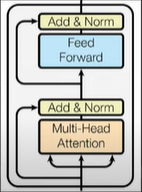

In [15]:
class TransformerBlock(nn.Module):
  def __init__ (self, embed_size, heads, dropout,forward_expansion):
    super(TransformerBlock, self).__init__()
    self.attention= SelfAttention(embed_size, heads)

    # we two norms as in the above picture
    # represents the size of the input embeddings.
    self.norm1=nn.LayerNorm(embed_size)
    self.norm2=nn.LayerNorm(embed_size)

    self.feed_forward= nn.Sequential(
        nn.Linear (embed_size, forward_expansion*embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size, embed_size)
    )

    self.dropout= nn.Dropout(dropout)

  def forward(self, value, key, query, mask):

    # This is calling the forward method of the SelfAttention class.
    attention= self.attention(value, key, query, mask)

    # self.norm1(attention * query) is the skip connection
    x= self.dropout(self.norm1(attention * query))

    # pass the out to the feed forward block
    forward  = self.feed_forward(x)

    # include the skip connection - final block of the decoder
    out = self.dropout(self.norm2(forward + x))

    return out

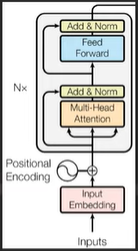

## nn.Embedding
The `nn.Embedding` layer in PyTorch is a simple lookup table that maps an index value to a weight matrix of a certain dimension.

Here are the key points about `nn.Embedding`:

1. **Lookup Table**: The `nn.Embedding` layer is a lookup table that maps an index value (e.g., a word index) to a corresponding embedding vector.

2. **Embedding Matrix**: The layer stores an embedding matrix, where each row represents an embedding vector for a particular index or token (e.g., a word).

3. **Trainable Parameters**: During training, the parameters of the embedding matrix are updated via backpropagation to minimize the loss function. This allows the model to learn a mapping from discrete input tokens to continuous embedding vectors in a high-dimensional space, where the vectors represent the meaning or context of the input tokens in relation to the task.

4. **Input and Output**: The input to the `nn.Embedding` layer is a list of indices, and the output is the corresponding word embeddings.

5. **Comparison to `nn.Linear`**: While `nn.Linear` expects vectors (e.g., one-hot representation of words) as input, `nn.Embedding` expects tokens (e.g., word indices). `nn.Embedding` simplifies the process by using word indices instead of large one-hot vectors.

6. **Initialization**: The embedding matrix can be initialized randomly or with pre-trained embeddings (e.g., Word2Vec, GloVe) to leverage the semantic information captured by these models.

7. **Padding**: The `padding_idx` parameter in `nn.Embedding` allows you to specify an index that will be used to initialize the embedding vector for padding tokens. This is useful when dealing with sequences of varying lengths.

In [7]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        # positional embedding is dependent by position
        # so we need to send the max_lenth of our sentences
        max_length,
    ):
      super(Encoder, self).__init__()
      self.embed_size = embed_size
      self.device = device
      self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
      self.position_embedding = nn.Embedding(max_length, embed_size)

      self.layers = nn.ModuleList(
        [
            TransformerBlock(
                embed_size=embed_size,
                heads=heads,
                dropout=dropout,
                forward_expansion=forward_expansion,
            )
        ]
    )

      self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
      N, seq_length = x.shape

      # getthe word positions to understand the permutation of the words
      # positions is a tensor representing the positions of each token in the sequences.
      positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

      # self.word_embedding(x) converts the input tokens x into their corresponding word embeddings
      out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

      for layer in self.layers:
          out = layer(out, out, out, mask)

      return out

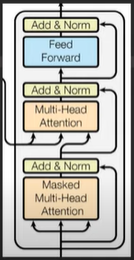

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

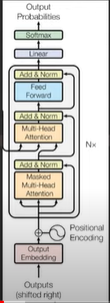

In [10]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    # x is the input embedding
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out

In [12]:
class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size=512,
      num_layers=6,
      forward_expansion=4,
      heads=8,
      dropout=0,
      device="cpu",
      max_length=100,
    ):
    super(Transformer, self).__init__()
    self.encoder = Encoder(
      src_vocab_size,
      embed_size,
      num_layers,
      heads,
      device,
      forward_expansion,
      dropout,
      max_length,
    )
    self.decoder = Decoder(
      trg_vocab_size,
      embed_size,
      num_layers,
      heads,
      forward_expansion,
      dropout,
      device,
      max_length,
      )
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    # (N, 1, 1, src_len)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )

    return trg_mask.to(self.device)

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_src, src_mask, trg_mask)
    return out

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
    device
)
trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 10
trg_vocab_size = 10
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
    device
)
out = model(x, trg[:, :-1])
print(out.shape)

cpu
torch.Size([2, 7, 10])
